# Neural Networks and Deep Learning

## Homework 3 - Reinforcement Learning

### Academic Year 2021/2022 
### Dr. Alberto Testolin, Dr. Umberto Michieli

### Capettini Croatto Hilario

In [1]:
### IMPORTS
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm 
from collections import deque # Python module useful for replay memory

import torch
from torch import nn
import gym
from IPython.display import clear_output

# For GIFS production
from PIL import Image
from IPython.display import Image as Gif_disp

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Experience replay 
"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

In [2]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        """Define a queue with maxlen capacity"""
        self.memory = deque(maxlen=capacity) 
    
    def push(self, state, action, next_state, reward):
        """Add the tuple (state, action, next_state, reward) to the queue"""
        self.memory.append((state, action, next_state, reward))
        
    def sample(self, batch_size):
        """randomly select batch_size samples"""
        batch_size = min(batch_size, len(self))
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Return the number of samples currently stored in memory"""
        return len(self.memory)
    

## Policy network

The policy network takes a **state** as input, and provides the Q-value for each of the possible **actions**.

In [3]:
class DQN(nn.Module):
    
    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim, out_features=100),
            nn.Tanh(),
            nn.Linear(in_features=100, out_features=200),
            nn.Tanh(),
            nn.Linear(in_features=200, out_features=100),
            nn.Tanh(),
            nn.Linear(in_features=100, out_features=action_space_dim)
                )
        
    def forward(self,x):
        return self.linear(x)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (**exploitation**), or maybe we want to find a better policy by choosing a different action (**exploration**).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Softmax policy

In [4]:
def choose_action_softmax(net, state, temperature):
    """With a softmax policy we choose the action based on a distribution obtained
       applying a softmax (with temperature  τ ) to the estimated Q-values. The highest
       the temperature, the more the distribution will converge to a random uniform 
       distribution. At zero temperature, instead, the policy will always choose the
       action with the highest Q-value."""
    
    if temperature < 0:
        raise Exeption("The temperature value must be greater or equal to 0")
    
    # Evaluate the network output from current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)    
    
    # If temperature is 0, just select the best action
    if temperature == 0:
        return int(net_out.argmax()) , net_out.numpy()
             
    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # Set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim = 0).numpy()
    
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p = softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

## Network update


### Update function

In [5]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
    """Makes a pass over a randomly sampled batch of the replay memory and update the network accordingly"""
    # Sample the data from replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    
    # Create tensors for each element of the batch
    states  = torch.tensor(np.array([s[0] for s in batch]),dtype = torch.float32)
    actions = torch.tensor(np.array([s[1] for s in batch]),dtype = torch.int64)
    rewards = torch.tensor(np.array([s[3] for s in batch]),dtype = torch.float32)
    
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)
    
    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))
    
    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    
    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

### training Loop

In [6]:
def initialization(param,state_space_dim,action_space_dim):
    """ This function initializes the different components of the reinforcement learning system
        (replay memory, networks) and also the optimizer and loss function"""
    ### Initialize the replay memory
    replay_mem = ReplayMemory(param["replay_memory_capacity"])

    ### Initialize the policy network
    policy_net = DQN(state_space_dim,action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.Adam(policy_net.parameters(), lr=param["lr"]) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [7]:
def training_lunar_lander(policy_net, target_net, replay_mem, optimizer, loss_fn, exploration_profile, env,
              param, verbose=True,reward_fn="original"):
    """ Training loop for the lunar lander."""

    final_score = []
    for episode_num, tau in enumerate(tqdm.tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until martians destroy the lander
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward_original, done, info = env.step(action)
            
            # MODIFY REWARD FUNCTION
            if reward_fn == "tweaked":
                x, y, vx, vy, angle, vangle = state[0], state[1], state[2], state[3], state[4], state[5]
                left_t, right_t = state[6], state[7]
                
                # bonus for going down
                bonus1 =  1.5*np.abs(vy) if vy <0 else 0
                # bonus for getting closer to the pad
                bonus2 = -1.5 * np.sqrt(x**2+y**2) 
            
                reward = reward_original + bonus1 + bonus2
                
            elif reward_fn =="original":
                reward = reward_original

            # Update the final score adding the reward
            score += reward

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += param["bad_state_penalty"]
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > param["min_samples_for_training"]: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, param["gamma"], optimizer, loss_fn, param["batch_size"])

            # Visually render the environment (disable to speed up the training)
            # WRITE SOME CODE TO SAVE THE IMAGES FOR GIFS

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % param["target_net_update_steps"] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose:
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        final_score.append(score)
    env.close()
    return final_score,policy_net

### Functions for visualization

In [8]:
def moving_average(x, w):
    """It estimates the moving average of a serie using a window of size w"""
    return np.convolve(x, np.ones(w), 'valid') / w

In [16]:
def plot_results(score,exploration_profile,title="",ymin=-100,ymax=300,yl=200,file_name="./Images/"):
    """Produce a plot with scores and temperature by iteration."""
    fig, ax = plt.subplots(figsize=(7,5))
    ax2 = ax.twinx()

    ax.plot(score, color='slategrey')
    ax.plot(moving_average(score, 50), color='navy')
    ax.axhline(y = yl, color = 'green', linestyle = '--')
    ax.set_ylim(ymin,ymax)
    ax.set_ylabel('Score')
    ax.legend(["Episodes score","Moving average of scores", "Game Solved" ])

    ax2.plot(exploration_profile, color='red')
    ax2.legend(["Temperature"], loc='upper center')
    ax2.set_ylabel('Temperature')

    ax.set_xlabel('Episode')
    ax.set_title(title)

    #plt.legend()
    plt.tight_layout()
    plt.savefig(file_name, format='svg')
    plt.show()

In [10]:
def test_function(environment,policy_net,get_gif=False,gif_name ="",verbose=True):
    """If get_frames is true then we recover a list with PIL images one for each survival frame"""
    state = environment.reset()
    score = 0
    survival_time = 0
    frames = []
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        if get_gif: frames.append(Image.fromarray(environment.render(mode="rgb_array")))
        action, q_values = choose_action_softmax(policy_net, state, temperature=0) # Choose the best action (temperature 0)
        next_state, reward, done, info = environment.step(action)              # Apply the action
        score += reward                                                        # Update scores
        state = next_state                                                     # Set the current state for the next iteration
        survival_time +=1
    if verbose: print(f"FINAL SCORE: {score}, SURVIVAL TIME: {survival_time}") 
    if get_gif: gif_creator(frames,f"./Images/{gif_name}.gif")
    

In [11]:
def gif_creator(image_list,name):
    return image_list[0].save(name,save_all=True, append_images=image_list[1:], duration=50, loop=0)

# Lunar Lander

**5 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms.**

In [12]:
#!pip install box2d pygame

**Action Space:**

There are four discrete actions available: `do nothing`, `fire left` orientation engine, `fire main engine`, `fire right` orientation engine.

**Observation Space:**

There are 8 states: the `coordinates of the lander` in x & y, its linear `velocities` in x & y, its angle, its `angular velocity`, and two booleans that represent whether each `leg is in contact` with the ground or not.

**Rewards:**

Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

## Default reward function

In [13]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [14]:
### Create environment
# Initialize the Gym environment
lander_env = gym.make("LunarLander-v2")
lander_env.reset(seed=0)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim  = lander_env.observation_space.shape[0]
action_space_dim = lander_env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [15]:
# Lists to save results
num_iterations = 1000

initial_value =  5
slope         =  6
exp_decay = np.exp(-np.log(initial_value) / num_iterations * slope)
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    
### PARAMETERS
parameters = {"gamma":                        0.99,
                  "batch_size":               128,
                  "bad_state_penalty":        0,
                  "min_samples_for_training": 1000,
                  "target_net_update_steps":  10,
                  "lr":                       1e-3,
                  "replay_memory_capacity":   10000
                  }


### Initialize the components
replay_mem, policy_net, target_net, optimizer, loss_fn = initialization(parameters,state_space_dim,action_space_dim)
### Train the network    
score, policy = training_lunar_lander(policy_net, target_net, replay_mem, optimizer, loss_fn, exploration_profile, lander_env,
                         parameters, verbose=False)

100%|██████████| 1000/1000 [1:40:49<00:00,  6.05s/it]


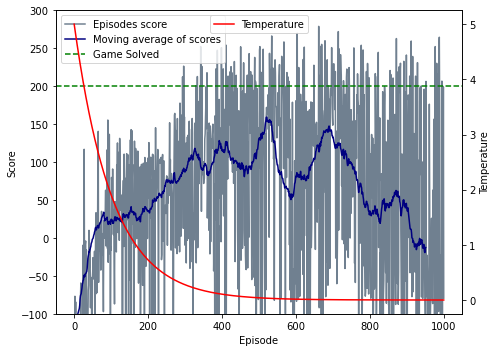

In [17]:
plot_results(score,exploration_profile,file_name='./Images/lander/lander_original_reward.svg')

In [30]:
# Save the best policy network
torch.save(policy.state_dict(),'./Best_Models/best_policy_net_lander_original.pth')

### Test

In [33]:
# Load the best model
policy_net = DQN(state_space_dim,action_space_dim)
policy_net.load_state_dict(torch.load('./Best_Models/best_policy_net_lander_original.pth'))

<All keys matched successfully>

In [20]:
# Initialize the Gym environment
lander_env = gym.make("LunarLander-v2") 
lander_env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 5 episodes
for num_episode in range(5): 
    test_function(lander_env,policy_net,get_gif=True,gif_name=f"lander/Trained_Lander_{num_episode}") 
lander_env.close()

FINAL SCORE: 134.3424792334597, SURVIVAL TIME: 528
FINAL SCORE: 182.6330483778104, SURVIVAL TIME: 390
FINAL SCORE: -299.7653197540034, SURVIVAL TIME: 531
FINAL SCORE: 251.28381938546985, SURVIVAL TIME: 296
FINAL SCORE: 191.98151235244706, SURVIVAL TIME: 558


In [21]:
Gif_disp(url="./Images/Lander_Gifs/Trained_Lander_3.gif")

## Tweaked reward function

In [22]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [23]:
### Create environment
# Initialize the Gym environment
lander_env = gym.make("LunarLander-v2")
lander_env.reset(seed=0)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim  = lander_env.observation_space.shape[0]
action_space_dim = lander_env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


In [24]:
# Lists to save results
num_iterations = 500

initial_value =  5
slope         =  6
exp_decay = np.exp(-np.log(initial_value) / num_iterations * slope)
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    
### PARAMETERS
parameters = {"gamma":                        0.99,
                  "batch_size":               128,
                  "bad_state_penalty":        0,
                  "min_samples_for_training": 1000,
                  "target_net_update_steps":  10,
                  "lr":                       1e-3,
                  "replay_memory_capacity":   10000
                  }


### Initialize the components
replay_mem, policy_net, target_net, optimizer, loss_fn = initialization(parameters,state_space_dim,action_space_dim)
### Train the network    
tw_score, tw_policy = training_lunar_lander(policy_net, target_net, replay_mem, optimizer, loss_fn, exploration_profile, lander_env,
                         parameters, verbose=False,reward_fn="tweaked")

100%|██████████| 500/500 [31:38<00:00,  3.80s/it]  


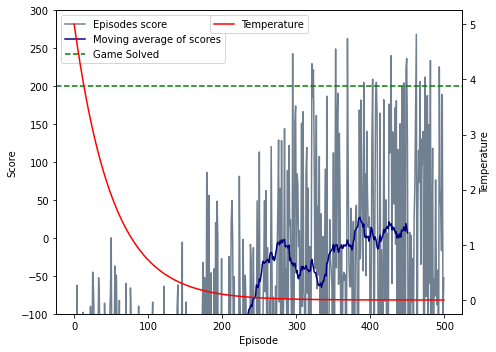

In [25]:
plot_results(tw_score, exploration_profile, file_name='./Images/lander/lander_tweaked_reward.svg')

In [31]:
# Save the best policy network
torch.save(tw_policy.state_dict(),'./Best_Models/best_policy_net_lander_tweaked.pth')

### Test

In [32]:
# Load the best model
policy_net = DQN(state_space_dim,action_space_dim)
policy_net.load_state_dict(torch.load('./Best_Models/best_policy_net_lander_tweaked.pth'))

<All keys matched successfully>

In [27]:
# Initialize the Gym environment
lander_env = gym.make("LunarLander-v2") 
lander_env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 5 episodes
for num_episode in range(5): 
    test_function(lander_env,tw_policy,get_gif=True,gif_name=f"lander/Trained_Tweaked_Lander_{num_episode}") 
lander_env.close()

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


FINAL SCORE: 189.60302784052266, SURVIVAL TIME: 334
FINAL SCORE: 260.9352902677844, SURVIVAL TIME: 220
FINAL SCORE: 242.00938661513052, SURVIVAL TIME: 276
FINAL SCORE: 47.32807335638546, SURVIVAL TIME: 124
FINAL SCORE: 53.1260328384372, SURVIVAL TIME: 136


In [29]:
Gif_disp(url="./Images/lander/Trained_Tweaked_Lander_1.gif")